# NYC restaurant data

my ongoing project in understanding NYC restaurant data
I would like to see how violations happen across the city, if there are some interesting trends to note there
Using this data set to learn exploration etc. 


In this notebook am interested in looking how the grades change over time. One of the first ideas that came to me was to aggregate all the grades in each month and plot that. That further evolved in changing the bin size of grade counts to 2 or 3 months, for a smoother curve. The data for the first year (July 2011 -- July 2012) is too sparse. It's unclear to me why those months do not contain enough inspections, and those data were left out in the end. 


I expect the number of grades to increase, and hopefully more As than any other grade, indicating that since 2012 Restaurants in NYC have conformed more to the cleanliness standards.



https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/xx67-kt59

#### Questions:
+ Are there more A grades being awarded over time? 
+ Could this be because the restaurants are becoming cleaner? 
+ NOTE: I've worked with Inspection Dates rather than Grade Dates so far; the choice was originally arbitrary, but I have no reason to believe this to cause a problem 

#### Next Steps To Do:
+ What if I did the same exercise for only the most popular cuisines
+ what is required to get an A vs. any other grade
    + meaning what is the maximum number/type of violation to still receive an A 


In [1]:
import pandas as pd
import numpy as np
import datetime as dt 
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

import ggplot

In [2]:
start = dt.datetime.now()
nydata = pd.read_csv('NYC_Resto.csv')

print "the loading took {} seconds ".format((dt.datetime.now()-start).seconds)

the loading took 3 seconds 


### Some Data cleaning
+ remove unnecessary columns
+ remove 'Missing' values from the BORO column
+ remove 'Null' grades 
+ rename columns (temp) 
+ new DataFrame: **dates**
+ rename columns with spaces for convenience
+ remove GRADE ==  'Not Yet Graded' 

In [3]:
# unnecessary columns
nydata = nydata.drop(['CAMIS','PHONE','ZIPCODE','STREET', 'BUILDING','RECORD DATE'], axis=1)
# 'Missing' Boros
nydata = nydata[nydata['BORO']!='Missing']
# Null Grades
full_grade=pd.notnull(nydata['GRADE'])
nydata=nydata[full_grade]
nydata['BORO'].value_counts()


# in the GRADE column: remove NYG and Z, P (far too few to matter!)
nydata=nydata[nydata['GRADE']!='Not Yet Graded']
nydata=nydata[nydata['GRADE']!='P']
nydata=nydata[nydata['GRADE']!='Z']
    # there are a total of  3086 Z grades, but they don't seem to affect the total 

### Work with smaller Data Frame
+ get a smaller DataFrame with just dates and grades (faster and smaller)
+ change Index to column:**'INSPECTION DATE'** 
+ create a DateTime Indexfrom "Inspection dates" 

In [4]:
#dates.index=dates.INSPECTION_DATE
start = dt.datetime.now()
dates = nydata[['INSPECTION DATE','GRADE']]
dates.index =pd.to_datetime(nydata['INSPECTION DATE'])
dates = dates.sort_index(axis=0)
print "this took {} seconds".format((dt.datetime.now()-start).seconds)

#this takes a while

this took 67 seconds


### remove the 2011 grades right away


When looking at the Cumulative Grades over time with bins of 1 month  (way below), taking all available data in consideration, the 'GRADES' data in the first year **( July-2011 to July-2012)** is sparse. As a result that part of the data is not meaningful when trying to plot what kind of grades were assigned over time. For instance, if DOHMH (Department of Health and Mental Hygene) assigned more A's, it could be because fewer violations were commited. Maybe as a result of changed policy? 
It makes sense to remove the first year of data altogether. The new DataFrame starts at **August 2012**


In [5]:
#the first 45 observations will be removed
column = ['2011-07-26', '2011-10-07', '2011-10-07', '2012-03-15',
               '2012-03-15', '2012-05-01', '2012-05-01', '2012-06-01',
               '2012-06-01', '2012-06-23', '2012-07-09', '2012-07-09', '2012-07-09', '2012-07-11',
               '2012-07-11', '2012-07-11', '2012-07-18', '2012-07-18',
               '2012-07-18', '2012-07-18', '2012-07-18', '2012-07-24',
               '2012-07-24', '2012-07-24', '2012-07-24', '2012-07-25',
               '2012-07-25', '2012-07-25', '2012-07-25', '2012-07-25',
               '2012-07-25', '2012-07-25', '2012-07-25', '2012-07-25',
               '2012-07-26', '2012-07-26', '2012-07-26', '2012-07-26',
               '2012-07-26', '2012-07-27', '2012-07-27', '2012-07-30',
               '2012-07-30', '2012-07-31', '2012-07-31']
dates = dates.drop(column, axis=0)

In [6]:
dates[-10:]

,INSPECTION DATE,GRADE
INSPECTION DATE,,
2016-08-05,08/05/2016,A
2016-08-05,08/05/2016,A
2016-08-05,08/05/2016,A
2016-08-05,08/05/2016,A
2016-08-05,08/05/2016,A
2016-08-05,08/05/2016,A
2016-08-05,08/05/2016,A
2016-08-05,08/05/2016,A
2016-08-05,08/05/2016,A


# Group Index: group by year-month


In [7]:
#these are the three grades we will be looking at
dates['GRADE'].unique()

array(['A', 'C', 'B'], dtype=object)

## Count up all Unique Grades in bins of one month
+ plots (in correct order, ie. year) for all the unique (A,B,C) grades
+ The first sampling is in 1M bins 
+ Change numeric month to Calendar Name (i.e. Jan, Feb, etc) 

In [6]:
#CALCULATE  ALL THE GRADES IN EACH MONTH
def get_grade_count_month(gradestring):
    # get the count of the grade in each month
    tmp_grade = dates[dates['GRADE']==gradestring][['GRADE']]
    
    #change index period to: Month, becomes PeriodIndex
    tmp_grade.index = tmp_grade.index.to_period('M')
    # group by date: DATE IS IN INDEX
    grouped = tmp_grade.groupby(tmp_grade.index)    
    
    return grouped.count()

# count up the grades in each month
grades_a = get_grade_count_month('A')
grades_b = get_grade_count_month('B')
grades_c = get_grade_count_month('C')


#change the numeric month to Calendar name
grades_a = grades_a.rename(index=lambda x:x.strftime('%Y-%B'))
grades_b = grades_b.rename(index=lambda x:x.strftime('%Y-%B'))
grades_c = grades_c.rename(index=lambda x:x.strftime('%Y-%B'))

It's best to place all the individual grade counts in one Data Frame

In [7]:
# put the Grade-counts for: A,B,C grades, into single DataFrame
tmp = grades_a

grades = tmp
grades['B Grades'] = grades_b
grades['C Grades '] = grades_c
##rename A Grades
grades = grades.rename(index=str, columns={"GRADE":"A Grades"})


In [8]:
# REMOVE August 2016 :: INvestigate why no B/C grades? This looks like incomplete data
grades = grades.drop('2016-August',axis=0)
grades[-5:]


,A Grades,B Grades,C Grades
INSPECTION DATE,,,
2016-March,5413,750.0,232.0
2016-April,5266,699.0,128.0
2016-May,5093,535.0,97.0
2016-June,4996,1135.0,295.0
2016-July,2645,100.0,56.0


In [9]:
grades_a =grades[['A Grades']]
#restore original grades_a

grades_a = grades_a.rename(index=str, columns={"A Grades": "GRADE"})
grades_a[-5:]

,GRADE
INSPECTION DATE,
2016-March,5413
2016-April,5266
2016-May,5093
2016-June,4996
2016-July,2645


### plot Dataframe grades; Total number of grades awarded, in bins of 1 Month

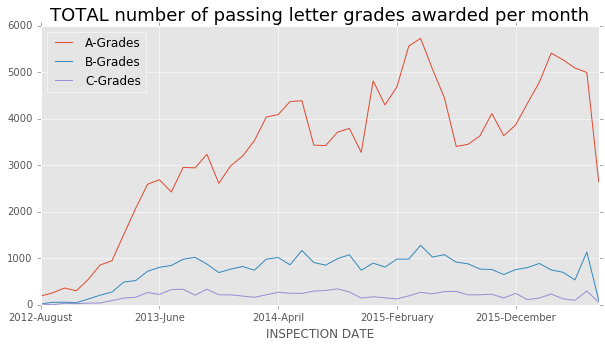

In [12]:
matplotlib.style.use('ggplot')

fig = plt.figure(figsize = (10,5))
    #this object's add_subplot method is then called for every plotting window
ax1 = fig.add_subplot(111)

grades.plot(ax=ax1)

plt.legend(['A-Grades', 'B-Grades','C-Grades'], loc='upper left')
plt.title( "TOTAL number of passing letter grades awarded per month", fontsize=18)


The raw numbers show that there are significantly more A-grades awarded to restaurants, than other grades. It may be useful at this point to scale the data
###What is the % share of each A grade of total number grades?




## TOTAL GRADES: use Resample to group Grade counts to every 2 Months
+ before grouping, pick only 'GRADE' column from dates DataFrame
+ before resample: need numeric data, use grouped .count()
+ API reference: http://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.DataFrame.resample.html

+ use original data:  **dates[['GRADE']]**
+ but afterwards: **remove August 2016** (like for grades DataFrame) 

In [13]:
# 1. change TIME PERIOD to month only for EACH OBSERVATION
tmp = dates[['GRADE']]
tmp.index = tmp.index.to_period('M')

# 2. group TOTAL number grades per month
grouped_dates = tmp.groupby(tmp.index)

# 3. count up the numer of grades in each month
dates_count=grouped_dates.count()


In [14]:
# remove August (if not already removed)
#dates_count = dates_count.drop('2016-August',axis=0)
#dates_count[-5:]

**dates_count** is a DataFrame containing TOTAL SUM of all grades in each month.
#### Now: resample to every x months , x=(2,3,4)
+ 4 months gives the most smooth curve

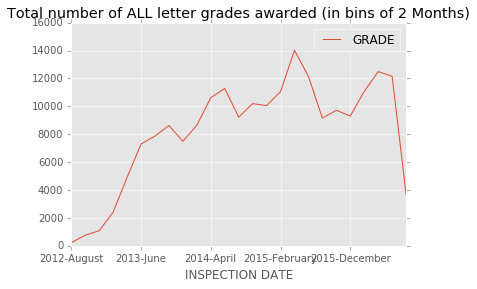

In [15]:
# Resample every 2 months
dates_count=dates_count.resample('2M', label='right').sum()
# change Index to remove 'day' 
dates_count.index = dates_count.index.to_period('M')

# change the month from numeric to Calendar name
# Does NOT count up number instances in each month *yet*
dates_count= dates_count.rename(index=lambda x:x.strftime('%Y-%B'))

dates_count.plot()
plt.title("Total number of ALL letter grades awarded (in bins of 2 Months)")

## RESAMPLE the letter=(A,B,C) grades every 2 months
+ grades_a (or, b,c) is numeric, Grade counts
+ can apply resample to change number of months
+ binS = size of bin bucket, 2, 3, 4 etc. (number months) 

In [16]:
# CHANGE Date Format to Y-M-D; where Day is 1st of Month
grades_a.index = pd.to_datetime(grades_a.index)
grades_b.index = pd.to_datetime(grades_b.index)
grades_c.index = pd.to_datetime(grades_c.index)

In [42]:
grades_c.shape
grades_a[-5:]

,GRADE
INSPECTION DATE,
2015-12-01,7503
2016-02-01,9120
2016-04-01,10679
2016-06-01,10089
2016-08-01,2645


In [17]:
binS = '2M' #binsize
def grade_binning(gradeDF):
    tmp_x = gradeDF.resample(binS).sum()
    #tmp_x.index = gradeDF.index.to_period('M')
    tmp_x = tmp_x.rename(index=lambda x:x.strftime('%Y-%B'))
    return tmp_x

grades_a = grade_binning(grades_a)
grades_b = grade_binning(grades_b)
grades_c = grade_binning(grades_c)


In [18]:
# get Grade % of Total 
grades_a_p2M =(grades_a/dates_count[['GRADE']])*100
grades_b_p2M =(grades_b/dates_count[['GRADE']])*100
grades_c_p2M =(grades_c/dates_count[['GRADE']])*100

#Plot for every 2 months

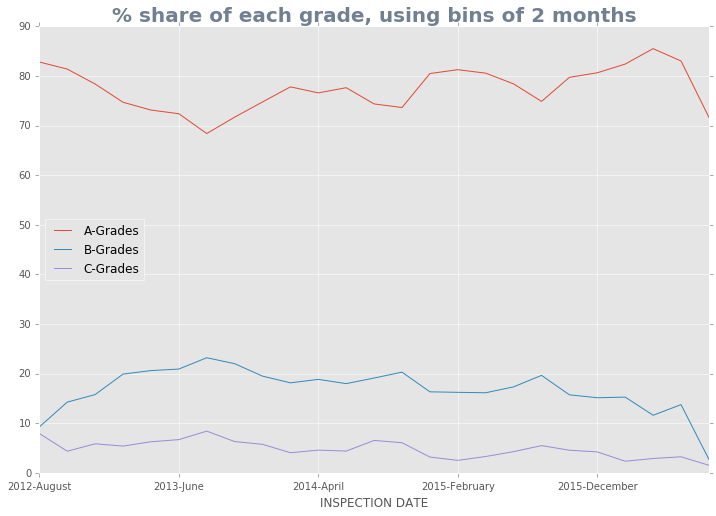

In [19]:
# test plots
matplotlib.style.use('ggplot')

fig = plt.figure(figsize = (12,8))
    #this object's add_subplot method is then called for every plotting window
ax1 = fig.add_subplot(111)
#ax2 = fig.add_subplot(211)
#ax3 = fig.add_subplot(111)

grades_a_p2M.plot(ax=ax1)
grades_b_p2M.plot(ax=ax1)
grades_c_p2M.plot(ax=ax1)
plt.legend(['A-Grades', 'B-Grades','C-Grades'], loc='center left')
plt.title("% share of each grade, using bins of 2 months", size=20, weight='demi',
          color='Slategrey')
# weight is bold, demi bold, etc. 

After an initial  decline the number of A grades awarded increases, while B and C grades are on the decline 